<a href="https://colab.research.google.com/github/Arrancara/gsoc_/blob/main/GSOC_Task_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


The notebook is an attempt to formalise and show the process that is taken to build a model that can be used for classification for lens.  Mixed data types are given, numerical, categorical and images.  Firstly, a purely image classifcation method is tested and then all of the data is taken into account. Model architecture similar to the previous task is taken for the image classifcation portion. 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

from astropy.visualization import astropy_mpl_style
plt.style.use(astropy_mpl_style)
from astropy.io import fits
from google.colab.patches import cv2_imshow
import cv2
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import numpy as np
import imageio
from PIL import Image
import os
import shutil
from cv2 import imwrite
from PIL import Image
import pandas as pd
import seaborn as sns
plt.rcParams["figure.figsize"] = (20, 12)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#Loading the Data



In [ ]:
master_df = pd.read_csv("/content/drive/MyDrive/SpaceBasedTraining/classifications.csv")

In [ ]:
names = os.listdir('/content/drive/MyDrive/SpaceBasedTraining/Data.0/Public/Band1/')
print(names)
master_df.head()

['imageEUC_VIS-105204.fits', 'imageEUC_VIS-112996.fits', 'imageEUC_VIS-101130.fits', 'imageEUC_VIS-109451.fits', 'imageEUC_VIS-111651.fits', 'imageEUC_VIS-114272.fits', 'imageEUC_VIS-106860.fits', 'imageEUC_VIS-107250.fits', 'imageEUC_VIS-111024.fits', 'imageEUC_VIS-106546.fits', 'imageEUC_VIS-116663.fits', 'imageEUC_VIS-109490.fits', 'imageEUC_VIS-105523.fits', 'imageEUC_VIS-101930.fits', 'imageEUC_VIS-117294.fits', 'imageEUC_VIS-110377.fits', 'imageEUC_VIS-109730.fits', 'imageEUC_VIS-110159.fits', 'imageEUC_VIS-114557.fits', 'imageEUC_VIS-100504.fits', 'imageEUC_VIS-100127.fits', 'imageEUC_VIS-110933.fits', 'imageEUC_VIS-116809.fits', 'imageEUC_VIS-102449.fits', 'imageEUC_VIS-115484.fits', 'imageEUC_VIS-102464.fits', 'imageEUC_VIS-107113.fits', 'imageEUC_VIS-115245.fits', 'imageEUC_VIS-106796.fits', 'imageEUC_VIS-115504.fits', 'imageEUC_VIS-113023.fits', 'imageEUC_VIS-104932.fits', 'imageEUC_VIS-109488.fits', 'imageEUC_VIS-117553.fits', 'imageEUC_VIS-104095.fits', 'imageEUC_VIS-11109

,ID,is_lens,Einstein_area,numb_pix_lensed_image,flux_lensed_image_in_sigma
0,100000,1,8.633760e-10,171,195.429
1,100001,1,1.317890e-10,294,855.589
2,100002,1,4.877250e-12,140,486.113
3,100003,1,1.440160e-09,1500,10467.400
4,100004,0,2.197350e-11,0,0.000


In [ ]:
print(np.shape(names), print(master_df.shape))

(18000, 5)
(9016,) None


There is clearly an inconsistency between the two number of datapoints.

In [ ]:
#Creating a new dataframe that contains the ID of the images and their path

names_df = pd.DataFrame({'ID':[(x.split('-')[1]).split(".")[0] for x in names], 
                         'Path':['/content/drive/MyDrive/SpaceBasedTraining/Data.0/Public/Band1/'
                          + x for x in names]})
names_df.head()

,ID,Path
0,105204,/content/drive/MyDrive/SpaceBasedTraining/Data...
1,112996,/content/drive/MyDrive/SpaceBasedTraining/Data...
2,101130,/content/drive/MyDrive/SpaceBasedTraining/Data...
3,109451,/content/drive/MyDrive/SpaceBasedTraining/Data...
4,111651,/content/drive/MyDrive/SpaceBasedTraining/Data...


In [ ]:
#Joining the two dataframes on the same ID
names_df["ID"] = names_df["ID"].astype("int64")
merged_df  = pd.merge(left=names_df, right=master_df, on="ID",
                      how="inner")
merged_df

,ID,Path,is_lens,Einstein_area,numb_pix_lensed_image,flux_lensed_image_in_sigma
0,105204,/content/drive/MyDrive/SpaceBasedTraining/Data...,0,5.158720e-10,0,0.000
1,112996,/content/drive/MyDrive/SpaceBasedTraining/Data...,0,8.823140e-11,0,0.000
2,101130,/content/drive/MyDrive/SpaceBasedTraining/Data...,1,2.081650e-10,444,1117.510
3,109451,/content/drive/MyDrive/SpaceBasedTraining/Data...,1,1.071440e-10,572,2533.010
4,111651,/content/drive/MyDrive/SpaceBasedTraining/Data...,1,1.184810e-10,439,615.832
...,...,...,...,...,...,...
9011,112460,/content/drive/MyDrive/SpaceBasedTraining/Data...,0,8.638950e-12,0,0.000
9012,109564,/content/drive/MyDrive/SpaceBasedTraining/Data...,1,1.473550e-11,274,780.773
9013,116892,/content/drive/MyDrive/SpaceBasedTraining/Data...,0,1.055870e-11,0,0.000
9014,113961,/content/drive/MyDrive/SpaceBasedTraining/Data...,1,1.743360e-11,333,1352.050


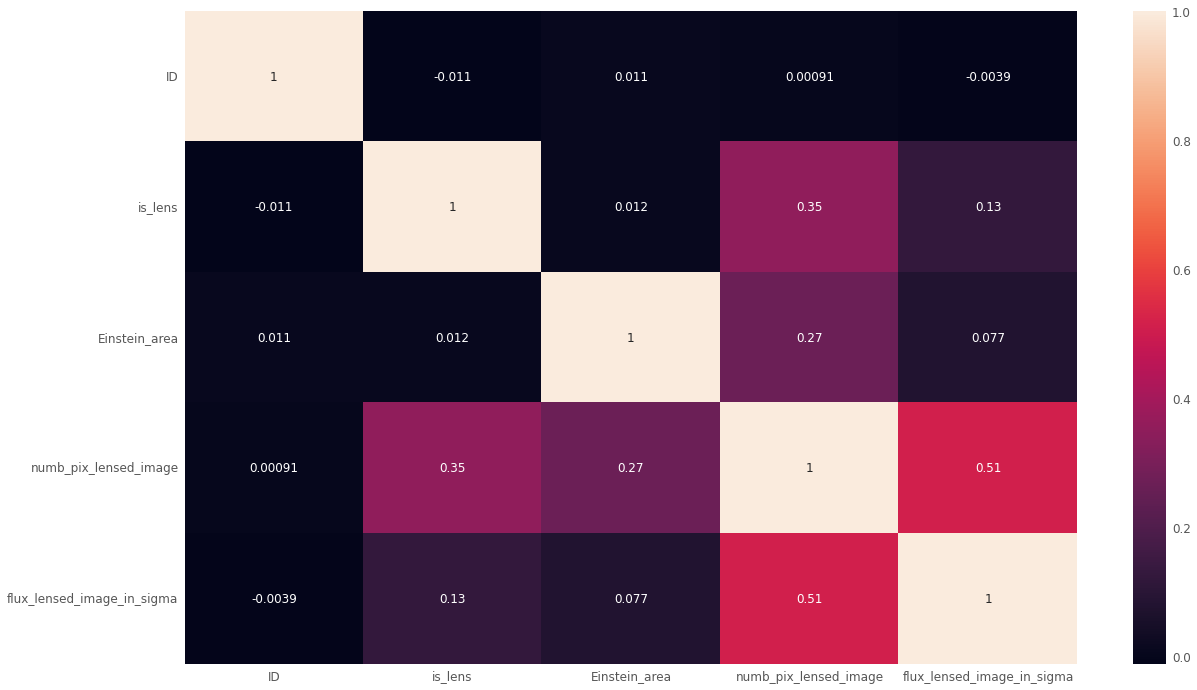

In [ ]:
sns.heatmap(merged_df.corr(), annot = True)

We can safely discard  columns regarding flux and pixels, as it isnt useful for this task, for the classifcation, these rows will only have non zero values iff 
is_lens = 1 (True). Therefore they are not important.

In [ ]:
merged_df = merged_df.drop(["numb_pix_lensed_image",
                            "flux_lensed_image_in_sigma"], axis=1)
merged_df

,ID,Path,is_lens,Einstein_area
0,105204,/content/drive/MyDrive/SpaceBasedTraining/Data...,0,5.158720e-10
1,112996,/content/drive/MyDrive/SpaceBasedTraining/Data...,0,8.823140e-11
2,101130,/content/drive/MyDrive/SpaceBasedTraining/Data...,1,2.081650e-10
3,109451,/content/drive/MyDrive/SpaceBasedTraining/Data...,1,1.071440e-10
4,111651,/content/drive/MyDrive/SpaceBasedTraining/Data...,1,1.184810e-10
...,...,...,...,...
9011,112460,/content/drive/MyDrive/SpaceBasedTraining/Data...,0,8.638950e-12
9012,109564,/content/drive/MyDrive/SpaceBasedTraining/Data...,1,1.473550e-11
9013,116892,/content/drive/MyDrive/SpaceBasedTraining/Data...,0,1.055870e-11
9014,113961,/content/drive/MyDrive/SpaceBasedTraining/Data...,1,1.743360e-11


In [ ]:
#Convert the dataset as numpy arrats and save them.

paths = []
from astropy.utils.data import get_pkg_data_filename
for i, row in merged_df.iterrows():
  picture_path = row['Path']
  img_name = (picture_path.split('Band1')[1]).split('.')[0]
  npz_path = picture_path.split('Band1')[0] + 'np' + img_name +".npz"
  paths.append(npz_path)
  temp_file = get_pkg_data_filename(picture_path)
  picture = fits.getdata(temp_file, ext=0)
  is_lens, ein_area = row["is_lens"], row["Einstein_area"]
  stats = np.array([ein_area])
  np.savez(npz_path, pic=picture, stats=stats, is_lens=is_lens)
merged_df['NP_Paths'] = pd.Series(paths)

merged_df.head()

In [ ]:
merged_df
#Obtaing a dataframe of only the stats
stats_df = merged_df[["Einstein_area"]]
stats_df


,Einstein_area
0,5.158720e-10
1,8.823140e-11
2,2.081650e-10
3,1.071440e-10
4,1.184810e-10
...,...
9011,8.638950e-12
9012,1.473550e-11
9013,1.055870e-11
9014,1.743360e-11


In [ ]:
#As we have sepeareted this data, we no longer need the current path and
# the stats data in the merged dataframe so we drop it.

merged_df.drop(["Path", "Einstein_area"], axis=1)

,ID,is_lens,NP_Paths
0,105204,0,/content/drive/MyDrive/SpaceBasedTraining/Data...
1,112996,0,/content/drive/MyDrive/SpaceBasedTraining/Data...
2,101130,1,/content/drive/MyDrive/SpaceBasedTraining/Data...
3,109451,1,/content/drive/MyDrive/SpaceBasedTraining/Data...
4,111651,1,/content/drive/MyDrive/SpaceBasedTraining/Data...
...,...,...,...
9011,112460,0,/content/drive/MyDrive/SpaceBasedTraining/Data...
9012,109564,1,/content/drive/MyDrive/SpaceBasedTraining/Data...
9013,116892,0,/content/drive/MyDrive/SpaceBasedTraining/Data...
9014,113961,1,/content/drive/MyDrive/SpaceBasedTraining/Data...


(101, 101) (1,)


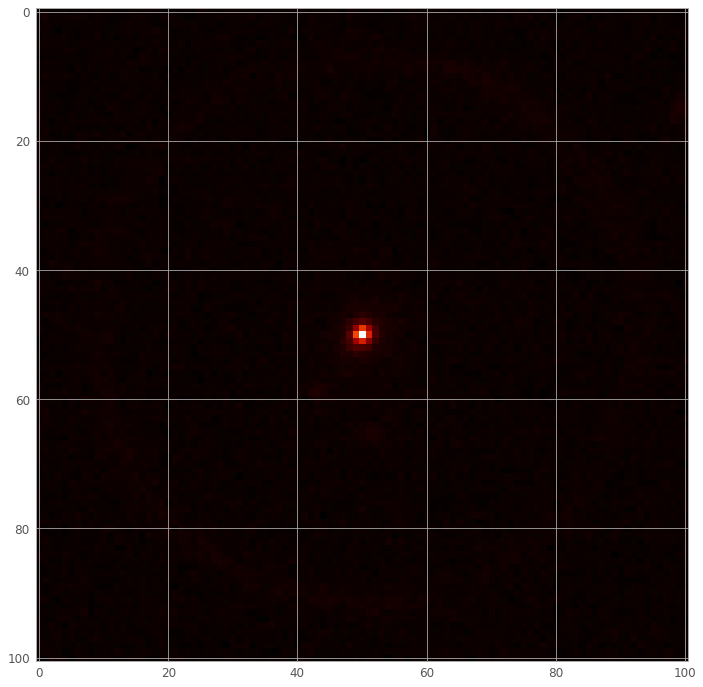

In [ ]:
#Loading in examples to check if its working properly

sample_npz = np.load(paths[30])
print(sample_npz["pic"].shape, sample_npz["stats"].shape)
plt.imshow(sample_npz["pic"])

#Data Processing

In [ ]:
shuffled_df = merged_df.sample(frac=1)
train_df, val_df = shuffled_df[:8100], shuffled_df[8100:]

print(np.shape(train_df), np.shape(val_df))

(8100, 5) (916, 5)


In [ ]:
def data_loader(df: pd.DataFrame):
  """
  Loads data into the ram. 
  """
  X_pics, X_stats = [], []
  labels = []
  for name in df['NP_Paths']:
    loaded_file = np.load(name)

    pic = loaded_file['pic']
    X_pics.append(pic)

    stats = loaded_file['stats']
    X_stats.append(stats)
    
    labels.append(loaded_file['is_lens'])

  X_pic, X_stats = np.array(X_pics), np.array(X_stats)
  labels = np.array(labels)

  return (X_pic, X_stats), labels

(X_train_pic, X_train_stats), y_train = data_loader(train_df)

In [ ]:
#Training data
print(np.shape(X_train_pic), np.shape(X_train_stats), np.shape(y_train))

print(pd.DataFrame(X_train_pic.flatten()).describe())
print(pd.DataFrame(X_train_stats).describe())


(8100, 101, 101) (8100, 1) (8100,)
                  0
count  8.262810e+07
mean   4.410974e-13
std    5.485874e-12
min   -4.289852e-12
25%   -4.187511e-13
50%    1.388119e-13
75%    7.361849e-13
max    2.174516e-09
                  0
count  8.100000e+03
mean   3.110070e-10
std    4.800833e-10
min    1.686280e-12
25%    5.422040e-12
50%    3.443905e-11
75%    4.534345e-10
max    1.883010e-09


I will indivually normalise the stats with mean 0 and std 1.

The pictures will be brought into a range of 0-255

In [ ]:
def rescaler(data:np.ndarray) -> np.ndarray:
  """
  Rescales the image to 0-255.0
  """
  new_array = ((data - np.amin(data))
   * (1/(np.amax(data) - np.amin(data)) * 255.0))
  return new_array

In [ ]:
X_train_pic = rescaler(X_train_pic)
print(pd.DataFrame(X_train_pic.flatten()).describe())

                  0
count  8.262810e+07
mean   2.353399e-01
std    6.646879e-01
min    0.000000e+00
25%    4.530604e-01
50%    5.183156e-01
75%    5.882301e-01
max    2.550000e+02


In [ ]:
(X_val_pic, X_val_stats), y_val = data_loader(val_df)
X_val_pic = rescaler(X_val_pic)

Normalising the stats

In [ ]:
print(pd.DataFrame(X_train_stats).describe())
X_train_stats = (X_train_stats-np.mean(X_train_stats))/(np.std(X_train_stats))
print(pd.DataFrame(X_train_stats).describe())

                  0
count  8.100000e+03
mean   3.110070e-10
std    4.800833e-10
min    1.686280e-12
25%    5.422040e-12
50%    3.443905e-11
75%    4.534345e-10
max    1.883010e-09
                  0
count  8.100000e+03
mean   1.565277e-16
std    1.000062e+00
min   -6.443462e-01
25%   -6.365642e-01
50%   -5.761189e-01
75%    2.966907e-01
max    3.274640e+00


In [ ]:
X_val_stats = (X_val_stats-np.mean(X_val_stats))/(np.std(X_val_stats))
print(pd.DataFrame(X_val_stats).describe())


                  0
count  9.160000e+02
mean  -1.981675e-17
std    1.000546e+00
min   -6.412801e-01
25%   -6.337001e-01
50%   -5.874373e-01
75%    3.472836e-01
max    3.075701e+00


For the model to work, we need to convert the file from BxHxW to BxHxWx3. This requires the image to be converted from grayscale to rgb.

In [ ]:
def grayscale_to_rgb(images, channel_axis=-1):
    images= np.expand_dims(images, axis=channel_axis)
    tiling = [1] * 4    # 4 dimensions: B, H, W, C
    tiling[channel_axis] *= 3
    images= np.tile(images, tiling)
    return images

In [ ]:
X_train_pic = grayscale_to_rgb(X_train_pic)
print(np.shape(X_train_pic))
X_val_pic = grayscale_to_rgb(X_val_pic)

(8100, 101, 101, 3)


##Model Generation

In [ ]:
from tensorflow.keras import layers
from tensorflow.keras.models import Model

from tensorflow.keras.applications import EfficientNetB3

def create_pre_trained_eff():
  pre_trained_model = EfficientNetB3(input_shape = (101,101,3),
                                  include_top = False, 
                                  weights="imagenet") 

  
  # for layer in pre_trained_model.layers:
  #   layer.trainable = False 
  return pre_trained_model
pre_trained_model_eff = create_pre_trained_eff()

last_layer = pre_trained_model_eff.get_layer('block7b_add')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output


# Flatten the output layer to 1 dimension
x = layers.GlobalAveragePooling2D()(last_output)
x = layers.Dense(128, activation='swish')(x)
x = layers.Dropout(0.4)(x)          
x = layers.Dense(64, activation='swish')(x)
x = layers.Dropout(0.35)(x)
x = layers.Dense(32, activation='swish')(x)

x = Model(pre_trained_model_eff.input, x) 


last layer output shape:  (None, 4, 4, 384)


In [ ]:
#Feed forward DNN for numerical data

input_stats = layers.Input(shape=(1,))
y = layers.Dense(64, activation="relu")(input_stats)
y = layers.Dense(32, activation="relu")(y)
y = layers.Dense(32, activation="relu")(y)

y = Model(inputs=input_stats, outputs=y)



In [ ]:
#Concatenating the two streams and define the final model.
# Concatenate the two streams together
combined = layers.concatenate([x.output, y.output])

# Define joined Feed-Forward Layer
z = layers.Dense(32, activation="relu")(combined)
z = layers.Dense(16, activation="relu")(z)
z = layers.Dense(16, activation="relu")(z)

z = layers.Dense(1, activation="sigmoid")(z)


# Define the final model
model = Model(inputs=[x.input, y.input], outputs=z)

In [ ]:
model.summary()

Model: "model_21"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_15 (InputLayer)          [(None, 101, 101, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_7 (Rescaling)        (None, 101, 101, 3)  0           ['input_15[0][0]']               
                                                                                                  
 normalization_7 (Normalization  (None, 101, 101, 3)  7          ['rescaling_7[0][0]']            
 )                                                                                                
                                                                                           

In [ ]:
#CallBack functions
#Callback
from keras.callbacks import ModelCheckpoint
#Automatically save the best weights for the model containg the best validation
#AuC score after each epoch.
checkpoint = ModelCheckpoint("/content/drive/MyDrive/gsoc_task_2",
                             monitor='val_auc', save_weights_only=True,
                             verbose=1, save_best_only=True, mode='max',
                             save_freq="epoch")
plateau = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_auc", factor=0.2,
                                               patience=10, verbose=0,
                                               mode="max")


In [ ]:
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.optimizers import Adam

model.compile(optimizer = RMSprop(learning_rate=2e-5),
              loss = tf.keras.metrics.binary_crossentropy,
              metrics=['accuracy', "AUC", "Recall", "Precision"])

In [ ]:
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.optimizers import Adam


history_initial = model.fit(x=[X_train_pic, X_train_stats],
                            y=y_train, validation_data=([X_val_pic, X_val_stats],
                                                        y_val),
                             epochs=10, callbacks=[checkpoint, plateau])

Epoch 1/10
 10/254 [>.............................] - ETA: 15:34 - loss: 0.7630 - accuracy: 0.3688 - auc: 0.4765 - recall: 0.1781 - precision: 0.6393

KeyboardInterrupt: ignored